In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import os
import sqlite3

# Preprocessing
#from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler

# Model
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
import optuna
import shap
import joblib
import keras

from scripts.config import DATA_PATH, MODELS_PATH

%load_ext autoreload
%autoreload 2

%load_ext tensorboard

from tempfile import mkdtemp
# Create a temp folder
cachedir = mkdtemp()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/home/ronan/code/Power_Price_Forecasting/scripts/preprocess_att.py:709: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Month'] = df['datetime'].dt.to_period('M')


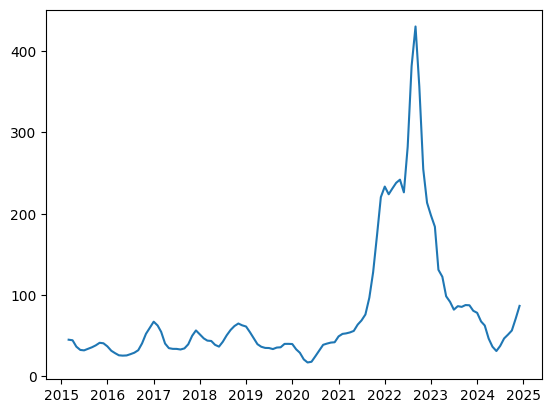

In [ ]:
model_data = pd.read_csv(os.path.join(DATA_PATH, 'ATT', 'model_data.csv'))

from scripts.preprocess_v5 import monthly_statistics

monthly_stats = monthly_statistics(model_data)

plt.plot(monthly_stats.index, monthly_stats['3-Month Rolling Average'])

# 1. Import processed data

In [9]:
data_dir = os.path.join(DATA_PATH, 'v3', 'classic')

X_past_train = np.load(os.path.join(data_dir, 'X_past_train.npy'))
X_future_train = np.load(os.path.join(data_dir, 'X_future_train.npy'))
X_past_val = np.load(os.path.join(data_dir, 'X_past_val.npy'))
X_future_val = np.load(os.path.join(data_dir, 'X_future_val.npy'))
X_past_test = np.load(os.path.join(data_dir, 'X_past_test.npy'))
X_future_test = np.load(os.path.join(data_dir, 'X_future_test.npy'))

X_past_train_transformed = np.load(os.path.join(data_dir, 'X_past_train_transformed.npy'))
X_future_train_transformed = np.load(os.path.join(data_dir, 'X_future_train_transformed.npy'))
X_past_val_transformed = np.load(os.path.join(data_dir, 'X_past_val_transformed.npy'))
X_future_val_transformed = np.load(os.path.join(data_dir, 'X_future_val_transformed.npy'))
X_past_test_transformed = np.load(os.path.join(data_dir, 'X_past_test_transformed.npy'))
X_future_test_transformed = np.load(os.path.join(data_dir, 'X_future_test_transformed.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
y_val = np.load(os.path.join(data_dir, 'y_val.npy'))
y_test = np.load(os.path.join(data_dir, 'y_test.npy'))

train_past_times = pd.read_pickle(os.path.join(data_dir, 'train_past_times.pkl'))
train_future_times = pd.read_pickle(os.path.join(data_dir, 'train_future_times.pkl'))
train_future_window_dates = pd.read_pickle(os.path.join(data_dir, 'train_future_window_dates.pkl'))

val_past_times = pd.read_pickle(os.path.join(data_dir, 'val_past_times.pkl'))
val_future_times = pd.read_pickle(os.path.join(data_dir, 'val_future_times.pkl'))
test_past_times = pd.read_pickle(os.path.join(data_dir, 'test_past_times.pkl'))
test_future_times = pd.read_pickle(os.path.join(data_dir, 'test_future_times.pkl'))



# 2. Forecast with simple LSTM

In [5]:
from scripts.model_lstm_v1 import LSTMModel

lstm_model = LSTMModel(
    preprocess_version="v3",
    # LSTM parameters
    lstm_units=32,        # Good starting point: ~2-4x number of features
    dense_units=16,        # Half of LSTM units for dimensionality reduction

    # Input dimensions (from your data)
    n_past_features=X_past_train_transformed.shape[2],
    n_future_features=X_future_train_transformed.shape[2],
    past_seq_len=X_past_train_transformed.shape[1],
    future_seq_len=X_future_train_transformed.shape[1],

    # Regularization
    dropout=0.3,           # Moderate dropout to prevent overfitting
    batch_normalization=True,

    # Training parameters
    learning_rate=0.001,   # Standard learning rate for Adam
    verbose=True,
    epochs_early_stopping=20,

    # Loss and metrics
    loss='mse',
    metrics=['mae', 'mape'],

    # Additional regularization
    regularization='l2',
    lambda_reg=0.01       # Small L2 penalty
)

lstm_model

Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 2005.4729 - mae: 39.4862 - mape: 100.5330 - val_loss: 2098.3638 - val_mae: 43.3317 - val_mape: 110372.9688 - learning_rate: 0.0010
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1807.5870 - mae: 38.7477 - mape: 102.2394 - val_loss: 2061.2700 - val_mae: 42.9996 - val_mape: 257165.5000 - learning_rate: 0.0010
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1757.2168 - mae: 38.6524 - mape: 104.8994 - val_loss: 2028.7781 - val_mae: 42.7384 - val_mape: 450701.9375 - learning_rate: 0.0010
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 1727.9873 - mae: 38.6388 - mape: 104.1187 - val_loss: 2001.8846 - val_mae: 42.5520 - val_mape: 679108.8125 - learning_rate: 0.0010
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1741.8605 - mae: 38.7868 - mape: 104.8747 - val_loss: 1984.0322 - val_mae: 42.4844 - val_mape: 873552.1250 - learning_rate: 0.0010
Epoch 6/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 

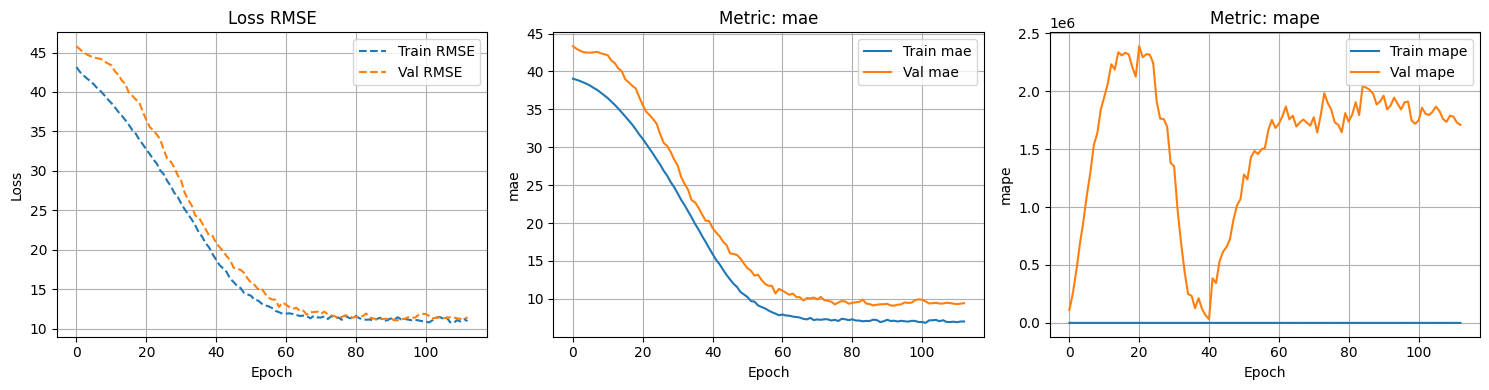

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 96.9921 - mae: 7.7699 - mape: 2886544.2500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 39.6181 - mae: 3.1612 - mape: 9.9699

Final Training Metrics:
RMSE: 7.1412
['mae', 'mape']: [3.1770379543304443, 12.365593910217285]

Final Validation Metrics:
RMSE: 11.0441
['mae', 'mape']: [9.11146068572998, 1876168.875]


In [6]:
lstm_model.fit(X_past_train_transformed, X_future_train_transformed, y_train, 
            X_past_val_transformed, X_future_val_transformed, y_val)


In [ ]:
from scripts.config import LOGS_PATH
%tensorboard --logdir {LOGS_PATH}/LSTM/fit

Launching TensorBoard...

In [8]:
test_results = lstm_model.model.evaluate(
            [X_past_test, X_future_test],
            y_test
        )

test_loss = np.sqrt(test_results[0])
test_metrics = test_results[1:]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Metrics: {test_metrics}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 162090745856.0000 - mae: 391606.6250 - mape: 4118015639552.0000
Test Loss: 410543.2140
Test Metrics: [400145.15625, 6004848721920.0]


In [ ]:
from scripts.model_att import AttentionModel
model_name = "20250820-135126"

att_model = AttentionModel.from_saved_model(model_name)

att_model

KeyError: 'parameters'

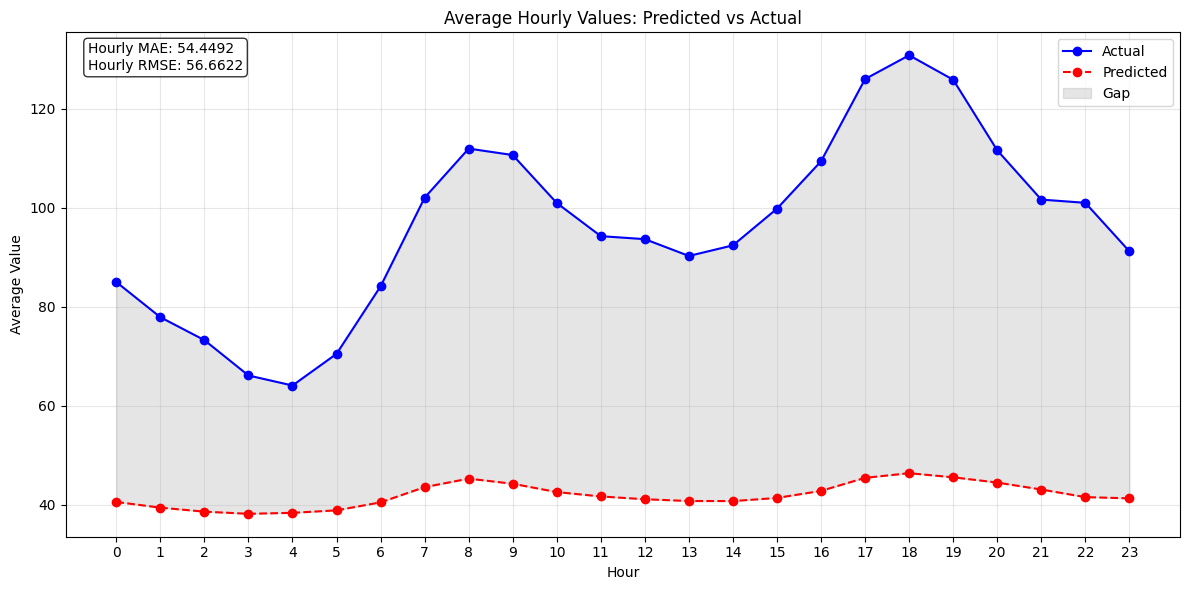

In [ ]:
pred = att_model.predict(X_past_test_transformed, X_future_test_transformed)

att_model.plot_hourly_averages(y_test, pred)

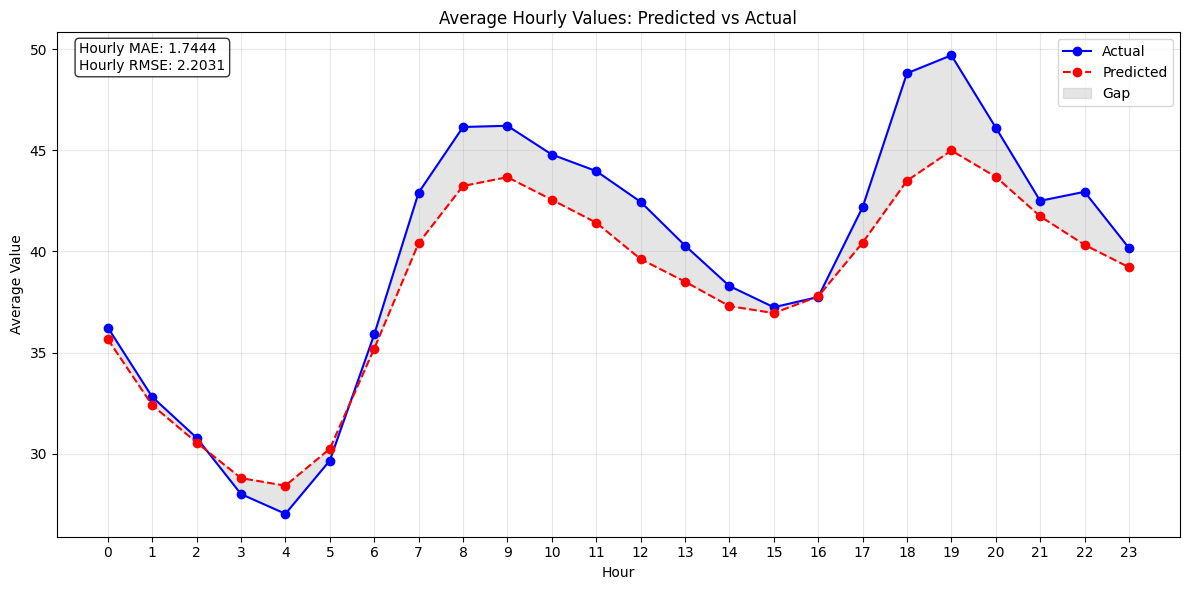

In [ ]:
pred = att_model.predict(X_past_train_transformed, X_future_train_transformed)

att_model.plot_hourly_averages(y_train, pred)